# timeseries

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
index = pd.Index([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
])
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]}, index=index).astype(np.float64)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  NaN
2018-01-04  4.0  2.0  2.0
2018-01-05  NaN  1.0  1.0


In [4]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [5]:
print(ts.fillna(-1))
%timeit big_ts.fillna(-1)

print(ts.vbt.timeseries.fillna(-1))
%timeit big_ts.vbt.timeseries.fillna(-1)

              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
6.35 ms ± 632 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
4.38 ms ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
print(ts.shift(3))
%timeit big_ts.shift(3)

print(ts.vbt.timeseries.fshift(3))
%timeit big_ts.vbt.timeseries.fshift(3)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
2.46 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
4.15 ms ± 636 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
print(ts.diff())
%timeit big_ts.diff()

print(ts.vbt.timeseries.diff())
%timeit big_ts.vbt.timeseries.diff()

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
5.12 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
6.42 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print(ts.pct_change())
%timeit big_ts.pct_change()

print(ts.vbt.timeseries.pct_change())
%timeit big_ts.vbt.timeseries.pct_change()

                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  0.0
2018-01-04  0.333333 -0.333333  0.0
2018-01-05  0.000000 -0.500000 -0.5
267 ms ± 5.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  NaN
2018-01-04  0.333333 -0.333333  NaN
2018-01-05       NaN -0.500000 -0.5
6.64 ms ± 49.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
print(ts.ffill())
%timeit big_ts.ffill()

print(ts.vbt.timeseries.ffill())
%timeit big_ts.vbt.timeseries.ffill()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
6.16 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
8.2 ms ± 29.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
print(ts.cumsum())
%timeit big_ts.cumsum()

print(ts.vbt.timeseries.cumsum())
%timeit big_ts.vbt.timeseries.cumsum()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
11.8 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
8.27 ms ± 58.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
print(ts.cumprod())
%timeit big_ts.cumprod()

print(ts.vbt.timeseries.cumprod())
%timeit big_ts.vbt.timeseries.cumprod()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
11.8 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
8.25 ms ± 63.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(ts.rolling(2).mean())
%timeit big_ts.rolling(2).mean()

print(ts.vbt.timeseries.rolling_mean(2))
%timeit big_ts.vbt.timeseries.rolling_mean(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
29.8 ms ± 595 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
14.2 ms ± 95.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
print(ts.rolling(2).std())
%timeit big_ts.rolling(2).std()

print(ts.vbt.timeseries.rolling_std(2))
%timeit big_ts.vbt.timeseries.rolling_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
54.2 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
19.7 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print(ts.rolling(2).min())
%timeit big_ts.rolling(2).min()

print(ts.vbt.timeseries.rolling_min(2))
%timeit big_ts.vbt.timeseries.rolling_min(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
42.9 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
16.8 ms ± 767 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
print(ts.rolling(2).max())
%timeit big_ts.rolling(2).max()

print(ts.vbt.timeseries.rolling_max(2))
%timeit big_ts.vbt.timeseries.rolling_max(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
43.6 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
16.4 ms ± 82.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
print(ts.expanding().max())
%timeit big_ts.expanding().max()

print(ts.vbt.timeseries.expanding_max())
%timeit big_ts.vbt.timeseries.expanding_max()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
49.2 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
9.85 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
print(ts.ewm(span=2).mean())
%timeit big_ts.ewm(span=2).mean()

print(ts.vbt.timeseries.ewm_mean(2))
%timeit big_ts.vbt.timeseries.ewm_mean(2)

                   a         b         c
2018-01-01  1.000000       NaN  1.000000
2018-01-02  1.750000  4.000000  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
87 ms ± 564 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.750000  4.000000  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
13 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
print(ts.ewm(span=2).std())
%timeit big_ts.ewm(span=2).std()

print(ts.vbt.timeseries.ewm_std(2))
%timeit big_ts.vbt.timeseries.ewm_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
474 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
21.9 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
nanmean_nb = njit(lambda x: np.nanmean(x))

In [19]:
print(ts.rolling(3).apply(nanmean_nb, raw=True)) # not correct
%timeit big_ts.rolling(3).apply(nanmean_nb, raw=True)

print(ts.vbt.timeseries.rolling_apply(3, nanmean_nb)) # correct
%timeit big_ts.vbt.timeseries.rolling_apply(3, nanmean_nb)

print(ts.vbt.timeseries.rolling_apply(3, nanmean_nb, on_2d=True))
%timeit big_ts.vbt.timeseries.rolling_apply(3, nanmean_nb, on_2d=True)

              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  NaN NaN
2018-01-03  2.0  NaN NaN
2018-01-04  3.0  3.0 NaN
2018-01-05  NaN  2.0 NaN
382 ms ± 5.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  2.0  3.5  1.5
2018-01-04  3.0  3.0  2.0
2018-01-05  3.5  2.0  1.5
45.4 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.750000  2.750000  2.750000
2018-01-05  2.285714  2.285714  2.285714
7.59 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(ts.expanding().apply(nanmean_nb, raw=True))
%timeit big_ts.expanding().apply(nanmean_nb, raw=True)

print(ts.vbt.timeseries.expanding_apply(nanmean_nb))
%timeit big_ts.vbt.timeseries.expanding_apply(nanmean_nb)

print(ts.vbt.timeseries.expanding_apply(nanmean_nb, on_2d=True))
%timeit big_ts.vbt.timeseries.expanding_apply(nanmean_nb, on_2d=True)

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
1.45 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
847 ms ± 6.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.400000  2.400000  2.400000
2018-01-05  2.166667  2.166667  2.166667
840 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print(ts['a'].groupby(np.asarray([1, 1, 2, 2, 3])).apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].groupby(np.random.randint(10, size=1000)).apply(lambda x: nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.groupby(np.asarray([1, 1, 2, 2, 3])).agg({
    'a': lambda x: nanmean_nb(x.values), 
    'b': lambda x: nanmean_nb(x.values), 
    'c': lambda x: nanmean_nb(x.values)})) # any clean way to do column-wise grouping in pandas?

print(ts.vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb, on_2d=True))

1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
3.76 ms ± 64.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
499 µs ± 99.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
6.53 ms ± 92.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     a    b    c
1  2.0  2.0  2.0
2  2.8  2.8  2.8
3  1.0  1.0  1.0


In [6]:
print(ts['a'].resample('1h').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1h').apply(lambda x: nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.resample('1h').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, :100].resample('1h').apply(lambda x: nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.vbt.timeseries.resample_apply('1h', nanmean_nb, on_2d=True))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_nb, on_2d=True)

2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
118 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
110 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                       a    b    c
2018-01-01 00:00:00  1.0  NaN  1.0
2018-01-01 01:00:00  NaN  NaN  NaN
2018-01-01 02:00:00  NaN  NaN  NaN
2018-01-01 03:00:00  NaN  NaN  NaN
201

In [7]:
print(ts['a'].resample('3d').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('3d').apply(lambda x: nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('3d', nanmean_nb)

print(ts.resample('3d').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.resample('3d').apply(lambda x: nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('3d', nanmean_nb)

2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float64
3.48 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float64
7.16 ms ± 71.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
3.49 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
329 ms ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
print(ts['a'].resample('1w').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1w').apply(lambda x: nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1w', nanmean_nb)

print(ts.resample('1w').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.resample('1w').apply(lambda x: nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1w', nanmean_nb)

2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float64
14.7 ms ± 5.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float64
9.88 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-07  2.5  2.5  1.5
3.98 s ± 1.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-07  2.5  2.5  1.5
149 ms ± 9.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
print(ts['a'].vbt.timeseries.rolling_window(2, n=2))
%timeit big_ts.iloc[:, 0].vbt.timeseries.rolling_window(2, n=100)

print(ts.vbt.timeseries.rolling_window(2, n=2))
%timeit big_ts.vbt.timeseries.rolling_window(2, n=100)

start_date  2018-01-01  2018-01-04
0                  1.0         4.0
1                  2.0         NaN
945 µs ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
start_date 2018-01-01           2018-01-04          
                    a    b    c          a    b    c
0                 1.0  4.0  NaN        2.0  1.0  2.0
1                 2.0  NaN  4.0        1.0  2.0  1.0
45.1 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


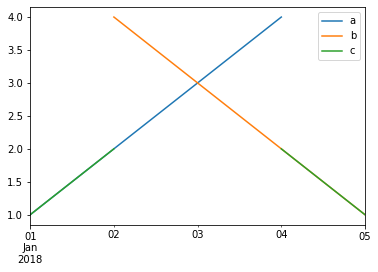

In [6]:
# Two ways of plotting
ts.plot()

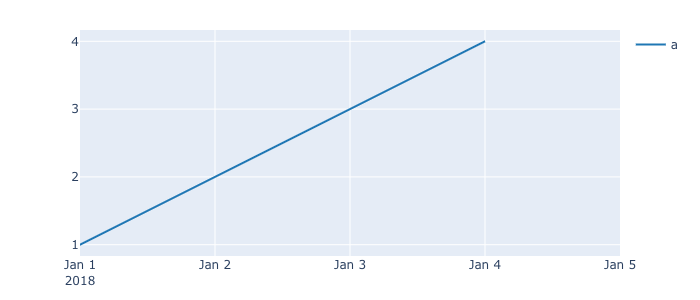

In [7]:
ts['a'].vbt.timeseries.plot().show_png()

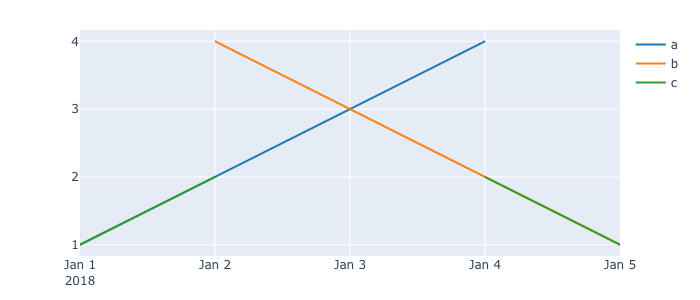

In [8]:
ts.vbt.timeseries.plot().show_png()

## OHLCV

In [9]:
ohlcv_ts = pd.DataFrame(
    columns=['Open', 'High', 'Low', 'Close', 'Volume'],
    index=[datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
)
ohlcv_ts['Open'] = np.cumsum(np.random.uniform(-0.8, 1, size=(1000,)))
ohlcv_ts['Close'] = ohlcv_ts['Open'] + np.random.uniform(-1, 1, size=(1000,))
ohlcv_ts['High'] = ohlcv_ts['Open'] + np.random.uniform(0, 1, size=(1000,))
ohlcv_ts['Low'] = ohlcv_ts['Open'] - np.random.uniform(0, 1, size=(1000,))
ohlcv_ts['Volume'] = np.cumsum(np.random.uniform(-1, 1, size=(1000,)))

print(ohlcv_ts.head())

                Open      High       Low     Close    Volume
2018-01-01  0.996138  1.598521  0.523267  0.833444  0.000940
2018-01-02  0.629759  1.617323  0.377078  0.116447  0.245807
2018-01-03  0.850013  1.773967  0.266527  0.033355  1.174050
2018-01-04  1.168259  1.173397  0.536548  1.999817  0.226275
2018-01-05  0.494530  1.086565 -0.330488  0.616773  0.459292


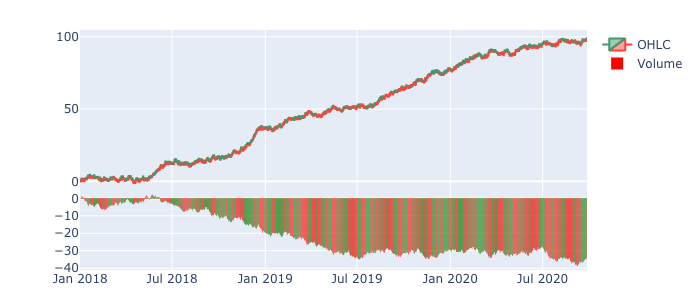

In [10]:
ohlcv_ts = ohlcv_ts.rename(columns={'Volume': 'Volume2'}) # test different column names

ohlcv_ts.vbt.ohlcv(volume='Volume2').plot().show_png()